# 합성곱 신경망 (CNN)

- 다양한 커널이 이미지에서 패턴을 골라낼수 있는데 이 정보(feature map)는 이미지를 분류할 대 굉장히 유용하다. 훈련시 제일 좋은 점수를 내는 커널을 쓰자. (이미지의 특징을 가장 잘 골라낸 커널을 얻자 ) 
- 여기서 얻은 정보를 결합해 신경망은 이미지를 분류하하게 된다. 쓸모 없는 커널은 가중치를 낮춰 그 영향력을 낮춘다.
- 커널의 모양을 인간이 지정하는 대신 네트워크가 알아서 훈련하게끔 위임하다. 

## MNIST CNN
- 합성곱 신경망에 익숙해지자. 
- GAN을 다루기 전에 합성곱 레이어를 이용해서 분류기 만드는 연습임

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [2]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [3]:
mnist_dataset=MnistDataset('C:/Users/Songwooseok/mnist_train.csv')

In [4]:

# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [7]:
class Classifier(nn.Module):
    
    def __init__(self):
        #부모클래스 초기화
        super().__init__()
        
        #신경망 레이어 정의 
        
        self.model = nn.Sequential(
        #1개(단색 이미지)의 필터에서 10개의 필터로(10개의 특성맵으로 10개의 커널을 만들겠다.) 
        nn.Conv2d(1,10,kernel_size=5,stride=2), 
        nn.LeakyReLU(0.02),
        nn.BatchNorm2d(10),
        #10개의 필터에서 10개의 필터로
        nn.Conv2d(10,10,kernel_size=3,stride=2), #5*5 크기의 특성맵을 얻었다.
        nn.LeakyReLU(0.02),
        nn.BatchNorm2d(10),
        
        View(250), # 5*5크기의 특성맵 10개 
        nn.Linear(250,10),
        nn.sigmoid()
        )
        #손실함수
        self.loss_function = nn.MSELoss()
        
        #SGD 옵티마이저
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)
        
        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        pass
    def forward(self,inputs):
        #모델실행
        return self.model(inputs)
    
    def train(self,inputs,targets):
        #신경망 출력 계산
        outputs =self.forward(inputs)
        
        #손실 계산
        loss = self.loss_function(outputs,targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad() #기울기 초기화
        loss.backward() #역전파 실행
        self.optimiser.step() #가중치 갱신

        pass
     
    def plot_progress(self): # 오차 출력 
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## 분류기 훈련시키기 

In [8]:
%%time 
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

AttributeError: module 'torch.nn' has no attribute 'sigmoid'

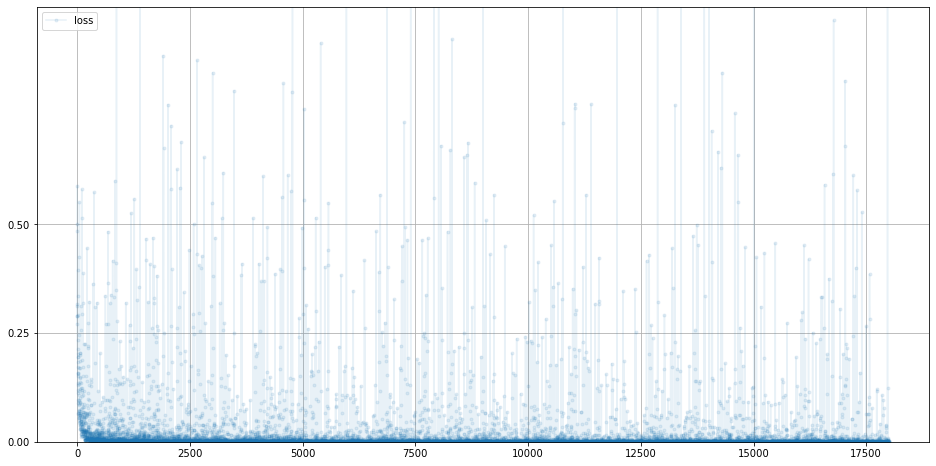

In [12]:
#분류기 오차출력
# plot classifier error

C.plot_progress()

## 훈련시킨 신경망에 쿼리하기

In [13]:
mnist_test_dataset=MnistDataset('C:/Users/Songwooseok/mnist_test.csv')


7


<AxesSubplot:>

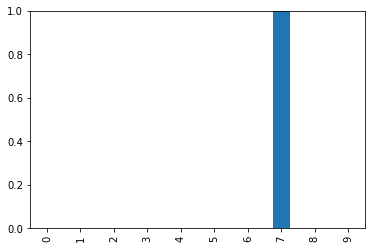

In [14]:
image_data =mnist_test_dataset[17][1]
print(mnist_test_dataset[17][0]) #label
#훈련된 신경망으로부터 쿼리
output = C.forward(image_data.view(1,1,28,28)) 

#tensor 출력
# 확률 : output.detach().numpy()
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))

In [16]:
score =0
items=0
for label,image_data_tensor,target_tensor in mnist_test_dataset:
    answer =C.forward(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax()==label):
        score += 1
        pass
    items +=1
    pass
print(score,items,score/items)

9789 10000 0.9789


# CelebA CNN


In [22]:
import h5py

import numpy
import matplotlib.pyplot as plt

In [30]:
# 217 *178픽셀 크기를 128*128로 버꾼다
def crop_centre(img, new_width,new_height):
    height, width, _=img.shape
    startx = width//2 - new_width//2
    starty =height//2 - new_height//2
    return img[  starty:starty +new_height, startx:startx +new_width, :]

In [31]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        #crop by 128*128
        img =crop_centre(img,128,128)
        
        return torch.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
        '''
        (batchsize,channels,height,width 반환) permute를 통해 (3,height,width )
        순서로 바꾸고, view로 배치크기 1을 추가해서 차원을 하나 더추가한다.
        '''
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        #crop by 128*128
        img =crop_centre(img,128,128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

In [23]:
celeba_dataset = CelebADataset('C:/Users/Songwooseok/wooseokcode/first GAN/celeba_dataset/celeba_aligned_small.h5py')

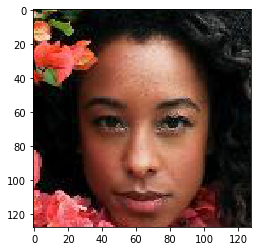

In [32]:
celeba_dataset.plot_image(43)

# 판별기

In [34]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [37]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

#생성기에 투입할 떄마다 쓰는 것 
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [38]:

%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
#D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.FloatTensor([0.0]))
    pass

counter =  1000


KeyboardInterrupt: 

In [39]:

# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass